# <center>Produisez une étude de marché avec Python
<img src=https://user.oc-static.com/upload/2020/11/24/16062164030098_image2.png>

## <span style="color : #8470FF">***Les librairies***</span> <a></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn import decomposition, preprocessing
from sklearn import cluster, metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# Permet d'afficher les graphiques dans un notebook
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## <span style="color : #8470FF">***Functions***</span> <a></a>

In [2]:
def plot_dendrogram(Z, names):
    plt.figure(figsize=(14,70))
    plt.title('Hierarchical Clustering Dendrogram', fontsize=22, weight='bold', color='Black',loc='center')
    plt.xlabel('Distance', weight='bold',size=16)
    plt.ylabel('Cluster Size', weight='bold',size=16)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=12)
    plt.axvline(x = 15, linewidth = 2, color = "dimgray", linestyle = "-.")
    dendrogram(
        Z,
        labels = names,
        orientation = "left", leaf_font_size=10
    )
    plt.show()

In [3]:
def display_scree_plot(pca):
    plt.figure(figsize=(9,8))
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree, color = '#1E90FF', edgecolor='darkblue')
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.axhline(y = 17, linewidth = .5, color = "dimgray", linestyle = "--") # ligne 17 = 100 / 6 (nb dimensions)
    plt.xlabel("Rang de l'axe d'inertie", weight='bold',size=16)
    plt.ylabel("Pourcentage d'inertie", weight='bold',size=16)
    plt.title("Éboulis des valeurs propres", fontsize=22, weight='bold', color='Black', loc='center')
    plt.show(block=False)

In [4]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(14,14))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='11', ha='right', va='center', rotation=label_rotation, color="black", alpha=0.8)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [5]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(10,10))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

## <span style="color : #8470FF">***Chargement et nettoyage des données***</span> <a></a>
## <span style="color : #00BFFF">**FAOSTAT_DisponibiliteAlimentaire.csv**</span> <a></a>

In [6]:
disali_df =  pd.read_csv('FAOSTAT_DisponibiliteAlimentaire.csv', sep=',')
disali_df= disali_df[['Area','Element','Item','Value']]
disali_df = disali_df.rename(columns={'Area':'Pays'})
disali_df

,Pays,Element,Item,Value
0,Afghanistan,Total Population - Both sexes,Population,36296.00
1,Afghanistan,Domestic supply quantity,Population,0.00
2,Afghanistan,Production,Wheat and products,4281.00
3,Afghanistan,Import Quantity,Wheat and products,3080.00
4,Afghanistan,Stock Variation,Wheat and products,208.00
...,...,...,...,...
186505,Zimbabwe,Food,Miscellaneous,15.00
186506,Zimbabwe,Food supply quantity (kg/capita/yr),Miscellaneous,1.02
186507,Zimbabwe,Food supply (kcal/capita/day),Miscellaneous,1.00
186508,Zimbabwe,Protein supply quantity (g/capita/day),Miscellaneous,0.03


## <span style="color : #00BFFF">**Disponibilité alimentaire - Volailles (Kcal/personne/jour)**</span> <a></a>

In [7]:
# Disponibilité alimentaire (Kcal/personne/jour)
disali_kcal = disali_df.loc[disali_df['Element'] == 'Food supply (kcal/capita/day)',:]
disali_kcal = disali_kcal.groupby(['Pays'])['Value'].sum().reset_index()
disali_kcal = disali_kcal.rename(columns={'Value':'Disponibilité alimentaire (Kcal/personne/jour)'})
# Disponibilité alimentaire - Viande de Volailles (Kcal/personne/jour)
disali_volaille_kcal = disali_df.loc[disali_df['Element'] == 'Food supply (kcal/capita/day)',:]
disali_volaille_kcal = disali_volaille_kcal.loc[disali_volaille_kcal['Item'] == 'Poultry Meat',:]
disali_volaille_kcal = disali_volaille_kcal.groupby(['Pays'])['Value'].sum().reset_index()
disali_volaille_kcal = disali_volaille_kcal.rename(columns={'Value':'Disponibilité alimentaire - Viande de Volailles (Kcal/personne/jour)'})
# Disponibilité alimentaire - Volailles (%)
merge_Kcal = pd.merge(disali_kcal, disali_volaille_kcal, on='Pays', how='left')
merge_Kcal.loc[:,"Proportion Disponibilité alimentaire - Viande de Volailles (%)"] = round((merge_Kcal['Disponibilité alimentaire - Viande de Volailles (Kcal/personne/jour)']/merge_Kcal['Disponibilité alimentaire (Kcal/personne/jour)'])*100,4)
merge_Kcal

,Pays,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité alimentaire - Viande de Volailles (Kcal/personne/jour),Proportion Disponibilité alimentaire - Viande de Volailles (%)
0,Afghanistan,2303.0,6.0,0.2605
1,Albania,3324.0,59.0,1.7750
2,Algeria,3380.0,24.0,0.7101
3,Angola,2436.0,36.0,1.4778
4,Antigua and Barbuda,2444.0,247.0,10.1064
...,...,...,...,...
175,Venezuela (Bolivarian Republic of),2353.0,57.0,2.4224
176,Viet Nam,2895.0,37.0,1.2781
177,Yemen,1991.0,32.0,1.6072
178,Zambia,2234.0,12.0,0.5372


## <span style="color : #00BFFF">**Disponibilité de protéines - Volailles (Kcal/personne/jour)**</span> <a></a>

In [8]:
# Disponibilité alimentaire (g/capita/day)
disali_protein = disali_df.loc[disali_df['Element'] == 'Protein supply quantity (g/capita/day)',:]
disali_protein = disali_protein.groupby(['Pays'])['Value'].sum().reset_index()
disali_protein = disali_protein.rename(columns={'Value':'Disponibilité de protéines (g/personne/jour)'})
disali_protein.loc[:,"Disponibilité de protéines (Kcal/personne/jour)"] = round((disali_protein['Disponibilité de protéines (g/personne/jour)'])*4,4)
# Disponibilité alimentaire - Viande de Volailles (g/capita/day)
disali_protein_volaille = disali_df.loc[disali_df['Element'] == 'Protein supply quantity (g/capita/day)',:]
disali_protein_volaille = disali_protein_volaille.loc[disali_protein_volaille['Item'] == 'Poultry Meat',:]
disali_protein_volaille = disali_protein_volaille.groupby(['Pays'])['Value'].sum().reset_index()
disali_protein_volaille = disali_protein_volaille.rename(columns={'Value':'Disponibilité de protéines - Viande de Volailles (g/personne/jour)'})
disali_protein_volaille.loc[:,"Disponibilité de protéines - Viande de Volailles (Kcal/personne/jour)"] = round((disali_protein_volaille['Disponibilité de protéines - Viande de Volailles (g/personne/jour)'])*4,4)
# Disponibilité de protéines - Volailles(%)
merge_protein = pd.merge(disali_protein, disali_protein_volaille, on='Pays', how='left')
merge_protein.loc[:,"Proportion Disponibilité de protéines - Viande de Volailles (%)"] = round((merge_protein['Disponibilité de protéines - Viande de Volailles (Kcal/personne/jour)']/merge_protein['Disponibilité de protéines (Kcal/personne/jour)'])*100,4)
merge_protein

,Pays,Disponibilité de protéines (g/personne/jour),Disponibilité de protéines (Kcal/personne/jour),Disponibilité de protéines - Viande de Volailles (g/personne/jour),Disponibilité de protéines - Viande de Volailles (Kcal/personne/jour),Proportion Disponibilité de protéines - Viande de Volailles (%)
0,Afghanistan,59.51,238.04,0.63,2.52,1.0586
1,Albania,114.68,458.72,4.44,17.76,3.8716
2,Algeria,88.59,354.36,2.13,8.52,2.4043
3,Angola,53.60,214.40,3.63,14.52,6.7724
4,Antigua and Barbuda,80.23,320.92,18.75,75.00,23.3703
...,...,...,...,...,...,...
175,Venezuela (Bolivarian Republic of),57.33,229.32,5.88,23.52,10.2564
176,Viet Nam,84.87,339.48,3.21,12.84,3.7823
177,Yemen,51.39,205.56,3.24,12.96,6.3047
178,Zambia,58.60,234.40,1.21,4.84,2.0648


## <span style="color : #00BFFF">**Exportations - Volailles Quantité (Milliers de tonnes)**</span> <a></a>

In [9]:
# Exportations Quantité (1000 tonnes)
disali_export = disali_df.loc[disali_df['Element'] == 'Export Quantity',:]
disali_export = disali_export.groupby(['Pays'])['Value'].sum().reset_index()
disali_export = disali_export.rename(columns={'Value':'Exportations - Quantité'})
# Exportations Quantité - Viande de Volailles (1000 tonnes)
disali_volaille_export = disali_df.loc[disali_df['Element'] == 'Export Quantity',:]
disali_volaille_export = disali_volaille_export.loc[disali_volaille_export['Item'] == 'Poultry Meat',:]
disali_volaille_export = disali_volaille_export.groupby(['Pays'])['Value'].sum().reset_index()
disali_volaille_export = disali_volaille_export.rename(columns={'Value':'Exportations - Viande de Volailles'})
# Exportations - Volailles (%)
merge_export = pd.merge(disali_export, disali_volaille_export, on='Pays', how='left')
merge_export.loc[:,"Proportion Exportations - Viande de Volailles (%)"] = round((merge_export['Exportations - Viande de Volailles']/merge_export['Exportations - Quantité'])*100,4)
merge_export['Exportations - Quantité'] = pd.to_numeric(merge_export['Exportations - Quantité'], errors='coerce')
merge_export['Exportations - Viande de Volailles'] = pd.to_numeric(merge_export['Exportations - Viande de Volailles'], errors='coerce')
merge_export['Proportion Exportations - Viande de Volailles (%)'] = pd.to_numeric(merge_export['Proportion Exportations - Viande de Volailles (%)'], errors='coerce')
merge_export = merge_export.fillna(value={'Exportations - Quantité': 0, 'Exportations - Viande de Volailles': 0, 'Proportion Exportations - Viande de Volailles (%)': 0})
merge_export

,Pays,Exportations - Quantité,Exportations - Viande de Volailles,Proportion Exportations - Viande de Volailles (%)
0,Afghanistan,628.00,0.0,0.0000
1,Albania,164.02,0.0,0.0000
2,Algeria,746.27,0.0,0.0000
3,Angola,129.03,0.0,0.0000
4,Antigua and Barbuda,0.09,0.0,0.0000
...,...,...,...,...
175,Venezuela (Bolivarian Republic of),55.09,0.0,0.0000
176,Viet Nam,31821.77,8.0,0.0251
177,Yemen,411.83,0.0,0.0000
178,Zambia,829.77,1.0,0.1205


## <span style="color : #00BFFF">**Importations - Volailles Quantité (Milliers de tonnes)**</span> <a></a>

In [10]:
# Importations Quantité (1000 tonnes)
disali_import = disali_df.loc[disali_df['Element'] == 'Import Quantity',:]
disali_import = disali_import.groupby(['Pays'])['Value'].sum().reset_index()
disali_import = disali_import.rename(columns={'Value':'Importations - Quantité'})
# Importations Quantité - Viande de Volailles (1000 tonnes)
disali_volaille_import = disali_df.loc[disali_df['Element'] == 'Import Quantity',:]
disali_volaille_import = disali_volaille_import.loc[disali_volaille_import['Item'] == 'Poultry Meat',:]
disali_volaille_import = disali_volaille_import.groupby(['Pays'])['Value'].sum().reset_index()
disali_volaille_import = disali_volaille_import.rename(columns={'Value':'Importations - Viande de Volailles'})
# Importations - Volailles (%)
merge_import = pd.merge(disali_import, disali_volaille_import, on='Pays', how='left')
merge_import.loc[:,"Proportion Importations - Viande de Volailles (%)"] = round((merge_import['Importations - Viande de Volailles']/merge_import['Importations - Quantité'])*100,4)
merge_import['Importations - Quantité'] = pd.to_numeric(merge_import['Importations - Quantité'], errors='coerce')
merge_import['Importations - Viande de Volailles'] = pd.to_numeric(merge_import['Importations - Viande de Volailles'], errors='coerce')
merge_import['Proportion Importations - Viande de Volailles (%)'] = pd.to_numeric(merge_import['Proportion Importations - Viande de Volailles (%)'], errors='coerce')
merge_import = merge_import.fillna(value={'Importations - Quantité': 0, 'Importations - Viande de Volailles': 0, 'Proportion Importations - Viande de Volailles (%)': 0})
merge_import

,Pays,Importations - Quantité,Importations - Viande de Volailles,Proportion Importations - Viande de Volailles (%)
0,Afghanistan,6112.00,29.0,0.4745
1,Albania,776.40,20.0,2.5760
2,Algeria,18102.15,2.0,0.0110
3,Angola,4223.83,277.0,6.5580
4,Antigua and Barbuda,71.32,7.0,9.8149
...,...,...,...,...
175,Venezuela (Bolivarian Republic of),5938.25,23.0,0.3873
176,Viet Nam,19632.47,62.0,0.3158
177,Yemen,6443.17,82.0,1.2727
178,Zambia,487.38,12.0,2.4621


## <span style="color : #00BFFF">**Population**</span> <a></a>

In [11]:
population_df =  pd.read_csv('Population_FAOSTAT_data.csv', sep=',')
population_df['Value'] = pd.to_numeric(population_df['Value'], errors='coerce')
population_df = population_df.fillna(value={'Value': 0})
population_df['Value'] = population_df['Value']*1000
population_df = population_df.rename(columns={'Area':'Pays'})
population_df = population_df.rename(columns={'Value':'Habitants'})
population_df = population_df.rename(columns={'Year':'Année'})
populationfinal_df = population_df[['Pays','Habitants']]
populationfinal_df

,Pays,Habitants
0,Afghanistan,36296113.0
1,Albania,2884169.0
2,Algeria,41389189.0
3,American Samoa,55620.0
4,Andorra,77001.0
...,...,...
232,Wallis and Futuna Islands,11900.0
233,Western Sahara,552615.0
234,Yemen,27834819.0
235,Zambia,16853599.0


## <span style="color : #00BFFF">**Stabilité Politique**</span> <a></a>

In [12]:
stabilité_politique_df =  pd.read_csv('Stabilité_Politique_FAOSTAT_data.csv', sep=',')
stabilité_politique_df['Value'] = pd.to_numeric(stabilité_politique_df['Value'], errors='coerce')
stabilité_politique_df = stabilité_politique_df.fillna(value={'Value': 0})
stabilité_politique_df = stabilité_politique_df.rename(columns={'Area':'Pays'})
stabilité_politique_df = stabilité_politique_df.rename(columns={'Value':'Stabilité Politique'})
stabilité_politique_df = stabilité_politique_df.rename(columns={'Year':'Année'})
stabilité_politiquefinal_df = stabilité_politique_df[['Pays','Stabilité Politique']]
stabilité_politiquefinal_df

,Pays,Stabilité Politique
0,Afghanistan,-2.80
1,Albania,0.38
2,Algeria,-0.92
3,American Samoa,1.22
4,Andorra,1.42
...,...,...
193,Venezuela (Bolivarian Republic of),-1.25
194,Viet Nam,0.29
195,Yemen,-2.94
196,Zambia,0.15


## <span style="color : #00BFFF">**Croissance de la Population (% annuel)**</span> <a></a>

In [13]:
croissance_population_df =  pd.read_csv('POP_GROW_data.csv', sep=';')
croissance_population_df['2017'] = pd.to_numeric(croissance_population_df['2017'], errors='coerce')
croissance_population_df = croissance_population_df.fillna(value={'2017': 0})
croissance_population_df = croissance_population_df.rename(columns={'Country Name':'Pays'})
croissance_population_df = croissance_population_df.rename(columns={'2017':'Croissance de la population (% annuel)'})
croissance_populationfinal_df = croissance_population_df[['Pays','Croissance de la population (% annuel)']]
croissance_populationfinal_df

,Pays,Croissance de la population (% annuel)
0,Aruba,0.471874
1,Africa Eastern and Southern,2.690902
2,Afghanistan,2.547833
3,Africa Western and Central,2.719330
4,Angola,3.322158
...,...,...
263,Kosovo,0.753585
264,Yemen,2.423989
265,South Africa,1.416947
266,Zambia,2.951463


## <span style="color : #00BFFF">**PIB par habitant ($ US courants)**</span> <a></a>

In [14]:
pib_habitant_df =  pd.read_csv('PIB_FAOSTAT_data.csv', sep=',')
pib_habitant_df['Value'] = pd.to_numeric(pib_habitant_df['Value'], errors='coerce')
pib_habitant_df = pib_habitant_df.fillna(value={'Value': 0})
pib_habitant_df = pib_habitant_df.rename(columns={'Area':'Pays'})
pib_habitant_df = pib_habitant_df.rename(columns={'Value':'PIB par habitant ($ US courants)'})
pib_habitant_df = pib_habitant_df.rename(columns={'Year':'Année'})
pib_habitantfinal_df = pib_habitant_df[['Pays','PIB par habitant ($ US courants)']]
pib_habitantfinal_df

,Pays,PIB par habitant ($ US courants)
0,Afghanistan,520.616409
1,Albania,4514.204908
2,Algeria,4109.696001
3,Andorra,38962.613799
4,Angola,4095.811686
...,...,...
206,Venezuela (Bolivarian Republic of),8432.288335
207,Viet Nam,2365.521494
208,Yemen,745.087677
209,Zambia,1534.874627


## <span style="color : #00BFFF">**Region/Pays**</span> <a></a>

In [15]:
# REGION / PAYS
region_df = pd.read_csv('RegionCountry.csv', sep=',')
region_df = region_df.rename(columns={'REGION (DISPLAY)':'Region'})
region_df = region_df.rename(columns={'COUNTRY (DISPLAY)':'Pays'})
regionfinal_df = region_df[['Pays','Region']]
regionfinal_df.set_index(['Pays'], inplace=True)
regionfinal_df

,Region
Pays,
Albania,Europe
American Samoa,Western Pacific
Andorra,Europe
Armenia,Europe
Australia,Western Pacific
...,...
United Arab Emirates,Eastern Mediterranean
Venezuela (Bolivarian Republic of),Americas
Viet Nam,Western Pacific


## <span style="color : #00BFFF">**Fusion des tableaux**</span> <a></a>

In [16]:
merge_pop_croissance = pd.merge(populationfinal_df, croissance_populationfinal_df, on='Pays', how='inner')
merge_pop_cro_pib = pd.merge(merge_pop_croissance, pib_habitantfinal_df, on='Pays', how='inner')
merge_pop_cro_pib_sp = pd.merge(merge_pop_cro_pib, stabilité_politiquefinal_df, on='Pays', how='inner')
merge_pop_cro_pib_sp_kcal = pd.merge(merge_pop_cro_pib_sp, merge_Kcal, on='Pays', how='inner')
merge_pop_cro_pib_sp_kcal_prot = pd.merge(merge_pop_cro_pib_sp_kcal, merge_protein, on='Pays', how='inner')
merge_pop_cro_pib_sp_kcal_prot_exp = pd.merge(merge_pop_cro_pib_sp_kcal_prot, merge_export, on='Pays', how='inner')
merge_pop_cro_pib_sp_kcal_prot_exp_imp = pd.merge(merge_pop_cro_pib_sp_kcal_prot_exp, merge_import, on='Pays', how='inner')
merge_pop_cro_pib_sp_kcal_prot_exp_imp

,Pays,Habitants,Croissance de la population (% annuel),PIB par habitant ($ US courants),Stabilité Politique,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité alimentaire - Viande de Volailles (Kcal/personne/jour),Proportion Disponibilité alimentaire - Viande de Volailles (%),Disponibilité de protéines (g/personne/jour),Disponibilité de protéines (Kcal/personne/jour),Disponibilité de protéines - Viande de Volailles (g/personne/jour),Disponibilité de protéines - Viande de Volailles (Kcal/personne/jour),Proportion Disponibilité de protéines - Viande de Volailles (%),Exportations - Quantité,Exportations - Viande de Volailles,Proportion Exportations - Viande de Volailles (%),Importations - Quantité,Importations - Viande de Volailles,Proportion Importations - Viande de Volailles (%)
0,Afghanistan,36296113.0,2.547833,520.616409,-2.80,2303.0,6.0,0.2605,59.51,238.04,0.63,2.52,1.0586,628.00,0.0,0.0000,6112.00,29.0,0.4745
1,Albania,2884169.0,-0.091972,4514.204908,0.38,3324.0,59.0,1.7750,114.68,458.72,4.44,17.76,3.8716,164.02,0.0,0.0000,776.40,20.0,2.5760
2,Algeria,41389189.0,2.044909,4109.696001,-0.92,3380.0,24.0,0.7101,88.59,354.36,2.13,8.52,2.4043,746.27,0.0,0.0000,18102.15,2.0,0.0110
3,Angola,29816766.0,3.322158,4095.811686,-0.33,2436.0,36.0,1.4778,53.60,214.40,3.63,14.52,6.7724,129.03,0.0,0.0000,4223.83,277.0,6.5580
4,Antigua and Barbuda,95426.0,0.952915,15383.415188,0.75,2444.0,247.0,10.1064,80.23,320.92,18.75,75.00,23.3703,0.09,0.0,0.0000,71.32,7.0,9.8149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,Venezuela (Bolivarian Republic of),29402484.0,-1.514766,8432.288335,-1.25,2353.0,57.0,2.4224,57.33,229.32,5.88,23.52,10.2564,55.09,0.0,0.0000,5938.25,23.0,0.3873
172,Viet Nam,94600648.0,1.020199,2365.521494,0.29,2895.0,37.0,1.2781,84.87,339.48,3.21,12.84,3.7823,31821.77,8.0,0.0251,19632.47,62.0,0.3158
173,Yemen,27834819.0,2.423989,745.087677,-2.94,1991.0,32.0,1.6072,51.39,205.56,3.24,12.96,6.3047,411.83,0.0,0.0000,6443.17,82.0,1.2727
174,Zambia,16853599.0,2.951463,1534.874627,0.15,2234.0,12.0,0.5372,58.60,234.40,1.21,4.84,2.0648,829.77,1.0,0.1205,487.38,12.0,2.4621


## <span style="color : #8470FF">***Table Final***</span> <a></a>

In [17]:
final_df = merge_pop_cro_pib_sp_kcal_prot_exp_imp
final_df = final_df[['Pays','Croissance de la population (% annuel)','PIB par habitant ($ US courants)','Stabilité Politique','Disponibilité alimentaire - Viande de Volailles (Kcal/personne/jour)','Proportion Disponibilité alimentaire - Viande de Volailles (%)','Importations - Viande de Volailles']]
final_df.set_index(['Pays'], inplace=True)
final_df

,Croissance de la population (% annuel),PIB par habitant ($ US courants),Stabilité Politique,Disponibilité alimentaire - Viande de Volailles (Kcal/personne/jour),Proportion Disponibilité alimentaire - Viande de Volailles (%),Importations - Viande de Volailles
Pays,,,,,,
Afghanistan,2.547833,520.616409,-2.80,6.0,0.2605,29.0
Albania,-0.091972,4514.204908,0.38,59.0,1.7750,20.0
Algeria,2.044909,4109.696001,-0.92,24.0,0.7101,2.0
Angola,3.322158,4095.811686,-0.33,36.0,1.4778,277.0
Antigua and Barbuda,0.952915,15383.415188,0.75,247.0,10.1064,7.0
...,...,...,...,...,...,...
Venezuela (Bolivarian Republic of),-1.514766,8432.288335,-1.25,57.0,2.4224,23.0
Viet Nam,1.020199,2365.521494,0.29,37.0,1.2781,62.0
Yemen,2.423989,745.087677,-2.94,32.0,1.6072,82.0


## <span style="color : #8470FF">***Classification Ascendante Hiérarchique (CAH)***</span> <a></a>

## <span style="color : #00BFFF">**Préparation des données**</span> <a></a>

In [18]:
# Préparation des données pour le Clustering
data = final_df.values
pays = final_df.index
features = final_df.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(data)
X_scaled = std_scale.transform(data)

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')

## <span style="color : #00BFFF">**Données en Scale**</span> <a></a>

In [19]:
data_scaled_df = pd.DataFrame(X_scaled, columns=final_df.columns, index=final_df.index)
data_scaled_df.head()

,Croissance de la population (% annuel),PIB par habitant ($ US courants),Stabilité Politique,Disponibilité alimentaire - Viande de Volailles (Kcal/personne/jour),Proportion Disponibilité alimentaire - Viande de Volailles (%),Importations - Viande de Volailles
Pays,,,,,,
Afghanistan,1.056075,-0.679427,-2.839633,-1.095756,-1.062530,-0.295583
Albania,-1.201518,-0.470671,0.529639,-0.236253,-0.337632,-0.338236
Algeria,0.625969,-0.491816,-0.847736,-0.803849,-0.847334,-0.423542
Angola,1.718288,-0.492541,-0.222620,-0.609245,-0.479883,0.879748
Antigua and Barbuda,-0.307918,0.097494,0.921662,2.812550,3.650099,-0.399846


## <span style="color : #00BFFF">**Dendrogramme**</span> <a></a>

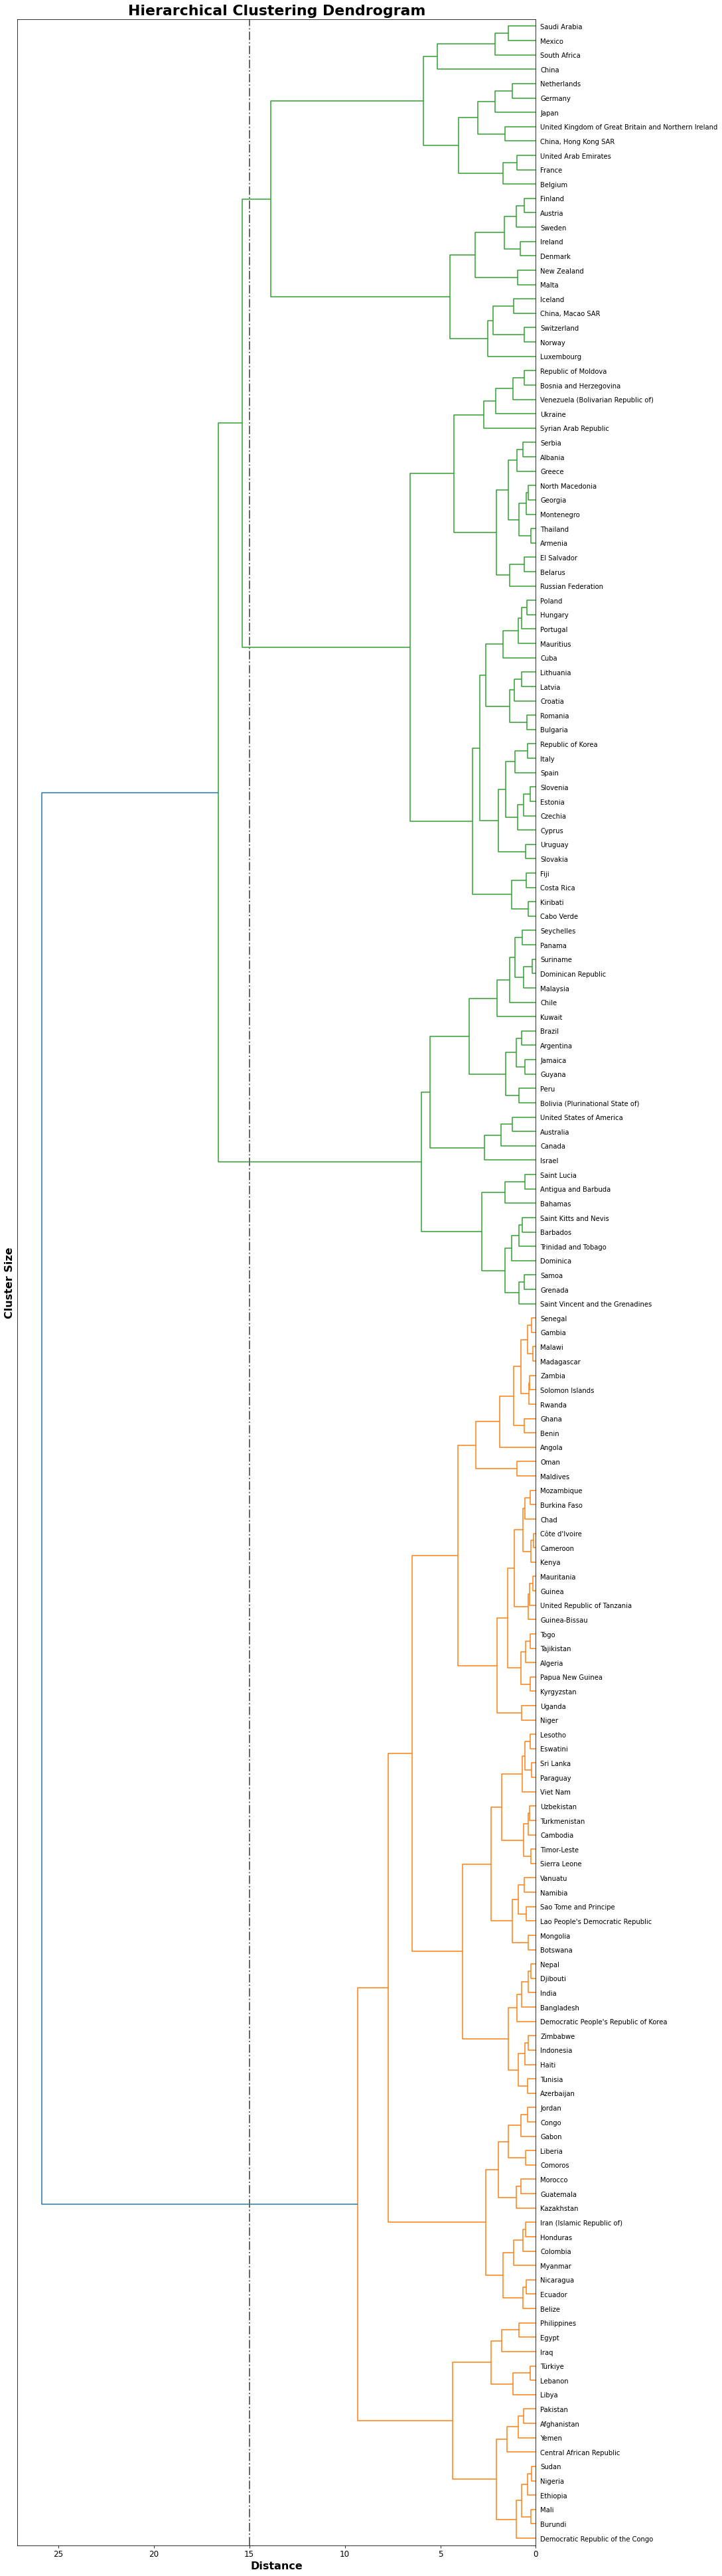

In [20]:
# Affichage du dendrogramme
plot_dendrogram(Z, pays)

## <span style="color : #00BFFF">**Regroupement des pays par région**</span> <a></a>

### <span style="color : #000000">**Coupage du dendrogramme en 4 clusters**</span> <a></a>

In [21]:
# Coupage du dendrogramme en 4 clusters
clusters = fcluster(Z, 4, criterion='maxclust')
#clusters = fcluster(Z, 15, criterion='distance') # Ligne équivalente à la précédente

# Region auxquels appartient les pays
region = [regionfinal_df.loc[pays_id, "Region"] for pays_id in final_df.index]

# Comparaison des clusters trouvés avec les classification des Pays par Region
paysregion = pd.DataFrame({"Region": region, "Pays": pays, "cluster": clusters })
print(paysregion)
print(paysregion.pivot_table(index="Region", columns="cluster", aggfunc=len, fill_value=0))

                    Region                                Pays  cluster
0    Eastern Mediterranean                         Afghanistan        1
1                   Europe                             Albania        3
2                   Africa                             Algeria        1
3                   Africa                              Angola        1
4                 Americas                 Antigua and Barbuda        2
..                     ...                                 ...      ...
171               Americas  Venezuela (Bolivarian Republic of)        3
172        Western Pacific                            Viet Nam        1
173  Eastern Mediterranean                               Yemen        1
174                 Africa                              Zambia        1
175                 Africa                            Zimbabwe        1

[176 rows x 3 columns]
                      Pays            
cluster                  1   2   3   4
Region                            

### <span style="color : #000000">**Tableau avec les 4 clusters**</span> <a></a>

In [22]:
groupes_cah = fcluster(Z, 4, criterion='maxclust') 

# Recuperation de la classe a laquelle appartient chaque pays
idg = np.argsort(groupes_cah)
ff = pd.DataFrame(data_scaled_df.index[idg], groupes_cah[idg])
ff['num_classe'] = ff.index

# Jointure avec le grand dataframe
df_global = pd.merge(data_scaled_df, ff, on='Pays', how='left')

#df_global.groupby(['num_classe']).size()
df_global.groupby("num_classe").mean()

,Croissance de la population (% annuel),PIB par habitant ($ US courants),Stabilité Politique,Disponibilité alimentaire - Viande de Volailles (Kcal/personne/jour),Proportion Disponibilité alimentaire - Viande de Volailles (%),Importations - Viande de Volailles
num_classe,,,,,,
1,0.694307,-0.555547,-0.572261,-0.660724,-0.600847,-0.266982
2,-0.264634,0.245783,0.589679,1.826915,1.857221,-0.262759
3,-1.235064,-0.070557,0.295730,0.002845,-0.053772,-0.154013
4,-0.183240,1.828857,0.906652,0.307694,0.151040,1.502563


## <span style="color : #00BFFF">**Heatmap (Dendrogramme - Classification Hiérarchique)**</span> <a></a>

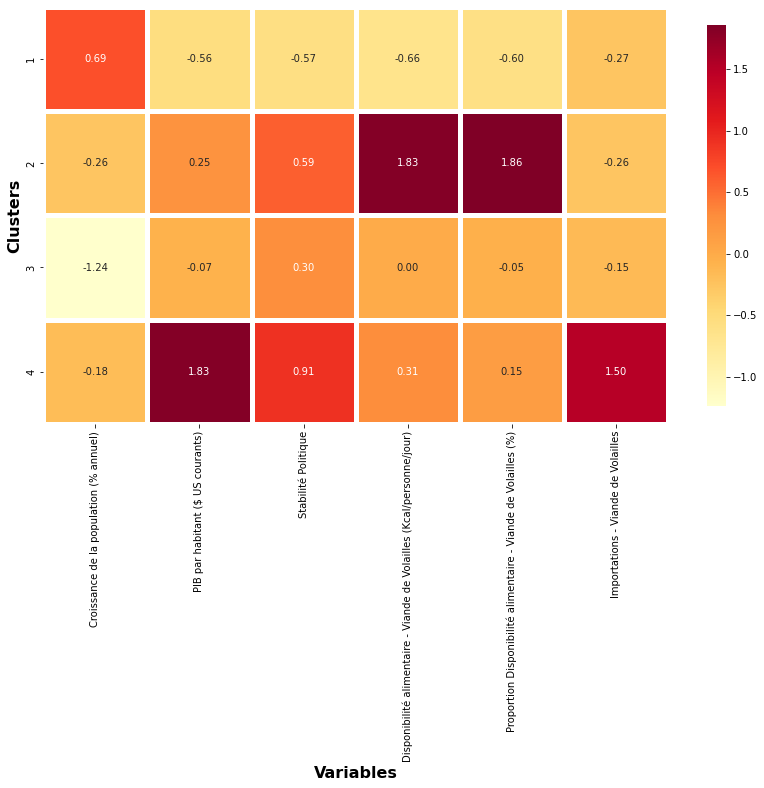

In [23]:
figde = df_global.groupby("num_classe").mean()
fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(figde, linewidth=5, annot = True, fmt='.2f', cmap="YlOrRd", cbar_kws={"shrink": 0.5}, square=True)
plt.ylabel("Clusters",weight='bold',size=16)
plt.xlabel("Variables",weight='bold',size=16)
plt.show()

In [24]:
# Cluster 4
# - Plus grande représentation dans le 'PIB para habitant' par rapport aux autres groupes.
# - Il a une meilleure Stabilité politique par rapport aux autres groupes.
# - Forte demande de Viande de volaille dans ces pays (Importations - Viande de Volailles).
# - Le taux de croissance de la population (% annuel) c'est un peu bas.
# - La disponibilité alimentaire - Viande de Volaille et sa Proportion par rapport a la disponibilité alimentaire global ne sont pas très forts.

# Cluster 2
# - La disponibilité alimentaire - Viande de Volaille et sa Proportion par rapport a la disponibilité alimentaire global sont très forts.
# - C'est le deuxième groupe avec une bonne Stabilité politique
# - Son 'PIB para habitant' est le deuxième meilleur
# - Son taux de croissance de la population (% annuel) est régulier.
# - Ils importent très peu de viande de volaille (Importations - Viande de Volailles)

# Les deux autres clusters ont des valeurs très faibles, ils ne seront donc pas pris en compte.
# Le meilleur groupe serait le groupe 4, car ces pays importent une grande quantité de viande de volaille,
# et grâce à leur stabilité politique et leur PIB, c'est une bonne indication pour pouvoir les cibler.
# Le groupe 2, en revanche, n'importe pas beaucoup de viande de volaille, 
# cela peut être dû au fait qu'ils sont des pays producteurs et que, 
# comme on le voit dans leur disponibilité alimentaire en viande de volaille, elle est également forte.


### <span style="color : #000000">**Liste des pays qui sont dans le Cluster 4**</span> <a></a>

In [25]:
# Jointure avec le grand Dataframe Final_df
df_global_hac = pd.merge(final_df, ff, on='Pays', how='left')
df_global_hac[df_global_hac.num_classe.isin([4])]

,Pays,Croissance de la population (% annuel),PIB par habitant ($ US courants),Stabilité Politique,Disponibilité alimentaire - Viande de Volailles (Kcal/personne/jour),Proportion Disponibilité alimentaire - Viande de Volailles (%),Importations - Viande de Volailles,num_classe
8,Austria,0.694621,47309.051637,1.05,65.0,1.7639,110.0,4
14,Belgium,0.385228,44025.903247,0.43,39.0,1.0342,312.0,4
31,China,0.605245,8889.173494,-0.23,65.0,1.9739,1543.0,4
32,"China, Hong Kong SAR",0.748223,46705.027813,0.83,182.0,5.5709,907.0,4
33,"China, Macao SAR",1.579114,81043.968656,1.43,140.0,4.2450,23.0,4
45,Denmark,0.643351,57938.797728,0.87,97.0,2.8555,133.0,4
56,Finland,0.234671,46385.550876,1.08,68.0,2.0378,16.0,4
57,France,0.290202,38720.645922,0.28,90.0,2.5648,506.0,4
61,Germany,0.373725,44651.829102,0.59,67.0,1.8900,842.0,4
72,Iceland,2.345583,73949.769216,1.35,104.0,2.8485,2.0,4


## <span style="color : #8470FF">***Méthode des k-means***</span> <a></a>

## <span style="color : #00BFFF">**Choix du nombre de classes avec  k -means**</span> <a></a>

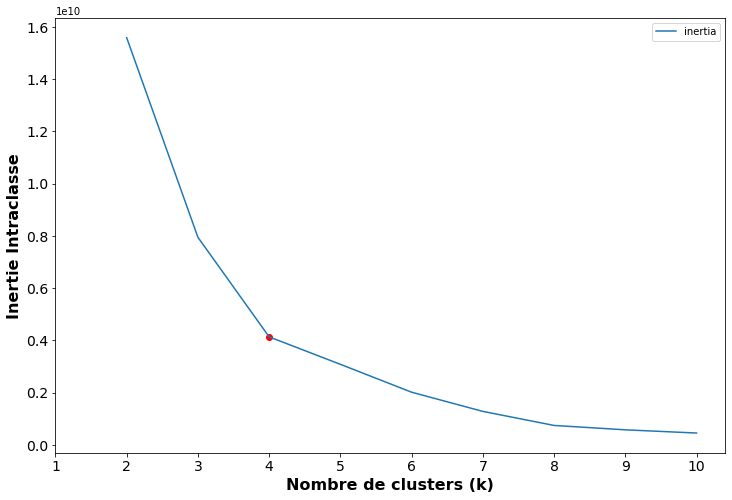

In [26]:
a=[]
for k in range(2,11):
    kmeans = cluster.KMeans(n_clusters=k, max_iter = 300) 
    kmeans.fit(data) 
    a.append(kmeans.inertia_)
a = pd.DataFrame({"k": range(2, 11), "inertia": a})
a.plot.line(x = "k", y = "inertia", figsize = (12,8))
plt.scatter(4, a.query('k == 4')["inertia"], c = "red")
plt.ylabel('Inertie Intraclasse', weight='bold',size=16)
plt.xlabel('Nombre de clusters (k)', weight='bold',size=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(np.arange(1, 11, 1))
plt.show()

### <span style="color : #000000">**Coupage en 4 clusters**</span> <a></a>

In [27]:
kmeans4 = KMeans(n_clusters = 4)
kmeans4.fit(data_scaled_df)

KMeans(n_clusters=4)

On peut avoir ainsi les classes de chaque individus (qui nous servent ici à calculer la taille de chaque classe), ainsi que les centres des classes.

### <span style="color : #000000">**Nombre d'individus par cluster**</span> <a></a>

In [28]:
pd.Series(kmeans4.labels_).value_counts()

1    75
3    53
2    24
0    24
dtype: int64

### <span style="color : #000000">**Centres des classes**</span> <a></a>

In [29]:
kmeans4.cluster_centers_

array([[-0.19098807,  1.91333142,  0.96757433,  0.31107225,  0.13613255,
         1.43700308],
       [ 0.79308938, -0.56503558, -0.6232593 , -0.77855044, -0.72053086,
        -0.26487272],
       [-0.28518263,  0.21784516,  0.55656895,  1.95845287,  1.99723343,
        -0.1917147 ],
       [-0.90667182, -0.16548245,  0.19179262,  0.07401283,  0.05356662,
        -0.18908428]])

### <span style="color : #000000">**Tableau avec les 4 clusters**</span> <a></a>

In [30]:
data_k4 = data_scaled_df.assign(classe = kmeans4.labels_)
data_k4_real = final_df.assign(classe = kmeans4.labels_)
#data_k4_real[data_k4_real.classe.isin([1])]
data_k4.groupby("classe").mean()

,Croissance de la population (% annuel),PIB par habitant ($ US courants),Stabilité Politique,Disponibilité alimentaire - Viande de Volailles (Kcal/personne/jour),Proportion Disponibilité alimentaire - Viande de Volailles (%),Importations - Viande de Volailles
classe,,,,,,
0,-0.190988,1.913331,0.967574,0.311072,0.136133,1.437003
1,0.793089,-0.565036,-0.623259,-0.778550,-0.720531,-0.264873
2,-0.285183,0.217845,0.556569,1.958453,1.997233,-0.191715
3,-0.906672,-0.165482,0.191793,0.074013,0.053567,-0.189084


## <span style="color : #00BFFF">**Heatmap (K-means)**</span> <a></a>

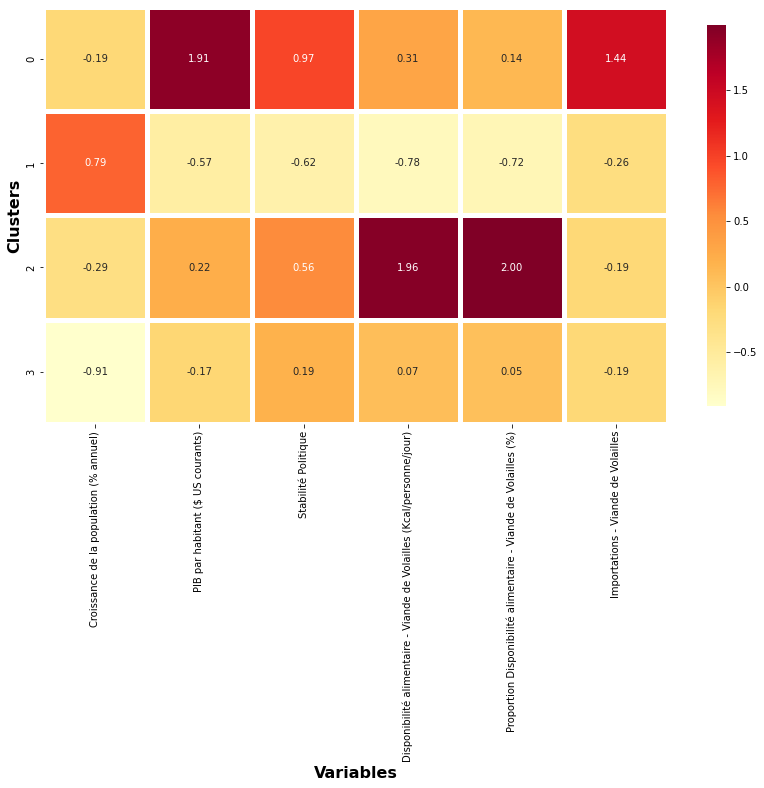

In [48]:
fig4 = data_k4.groupby("classe").mean()
fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(fig4, linewidth=5, annot = True, fmt='.2f', cmap="YlOrRd", cbar_kws={"shrink": 0.5}, square=True)
plt.ylabel("Clusters",weight='bold',size=16)
plt.xlabel("Variables",weight='bold',size=16)
#fig.savefig("output.png")
plt.show()

In [32]:
# On a quasiment le même résultat que dans sa Classification Hiérarchique

# Cluster 0
# - Plus grande représentation dans le 'PIB para habitant' par rapport aux autres groupes.
# - Il a une meilleure Stabilité politique par rapport aux autres groupes.
# - Forte demande de Viande de volaille dans ces pays (Importations - Viande de Volailles).
# - Le taux de croissance de la population (% annuel) c'est un peu bas.
# - La disponibilité alimentaire - Viande de Volaille et sa Proportion par rapport a la disponibilité alimentaire global ne sont pas très forts.

# Cluster 2
# - La disponibilité alimentaire - Viande de Volaille et sa Proportion par rapport a la disponibilité alimentaire global sont très forts.
# - C'est le deuxième groupe avec une bonne Stabilité politique
# - Son 'PIB para habitant' est le deuxième meilleur
# - Son taux de croissance de la population (% annuel) est régulier.
# - Ils importent très peu de viande de volaille (Importations - Viande de Volailles)

# Les deux autres clusters ont des valeurs très faibles, ils ne seront donc pas pris en compte.
# Le meilleur groupe serait le groupe 3, car ces pays importent une grande quantité de viande de volaille,
# et grâce à leur stabilité politique et leur PIB, c'est une bonne indication pour pouvoir les cibler.
# Le groupe 2, en revanche, n'importe pas beaucoup de viande de volaille, 
# cela peut être dû au fait qu'ils sont des pays producteurs et que, 
# comme on le voit dans leur disponibilité alimentaire en viande de volaille, elle est également forte.

### <span style="color : #000000">**Liste des pays qui sont dans le Cluster 0**</span> <a></a>

In [46]:
data_k4_real[data_k4_real.classe.isin([0])]

,Croissance de la population (% annuel),PIB par habitant ($ US courants),Stabilité Politique,Disponibilité alimentaire - Viande de Volailles (Kcal/personne/jour),Proportion Disponibilité alimentaire - Viande de Volailles (%),Importations - Viande de Volailles,classe
Pays,,,,,,,
Austria,0.694621,47309.051637,1.05,65.0,1.7639,110.0,0
Belgium,0.385228,44025.903247,0.43,39.0,1.0342,312.0,0
Canada,1.199521,44906.748920,1.10,154.0,4.3975,182.0,0
China,0.605245,8889.173494,-0.23,65.0,1.9739,1543.0,0
"China, Hong Kong SAR",0.748223,46705.027813,0.83,182.0,5.5709,907.0,0
"China, Macao SAR",1.579114,81043.968656,1.43,140.0,4.2450,23.0,0
Denmark,0.643351,57938.797728,0.87,97.0,2.8555,133.0,0
Finland,0.234671,46385.550876,1.08,68.0,2.0378,16.0,0
France,0.290202,38720.645922,0.28,90.0,2.5648,506.0,0


## <span style="color : #8470FF">***Analyse en Composantes Principales (ACP)***</span> <a></a>

## <span style="color : #00BFFF">**Préparation des données**</span> <a></a>

In [34]:
# choix du nombre de composantes à calculer
n_comp = 6

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=6)

### <span style="color : #000000">**Variance expliquée**</span> <a></a>

In [35]:
#Variance expliquée
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[2.75813988 1.11838938 0.91499261 0.81331163 0.41679605 0.01265616]
[0.45707811 0.18533915 0.1516323  0.13478176 0.06907131 0.00209738]


### <span style="color : #000000">**Tableau récapitulatif, avec les variances expliquées**</span> <a></a>

In [36]:
eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(6)], 
        "Variance expliquée" : pca.explained_variance_,
        "Variance expliquée (%)" : np.round(pca.explained_variance_ratio_ * 100,1),
        "Cum. var. expliquée (%)" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100,1)
    }
)
eig

,Dimension,Variance expliquée,Variance expliquée (%),Cum. var. expliquée (%)
0,Dim1,2.758140,45.7,45.7
1,Dim2,1.118389,18.5,64.2
2,Dim3,0.914993,15.2,79.4
3,Dim4,0.813312,13.5,92.9
4,Dim5,0.416796,6.9,99.8
5,Dim6,0.012656,0.2,100.0


### <span style="color : #000000">**Eboulis des valeurs propres**</span> <a></a>

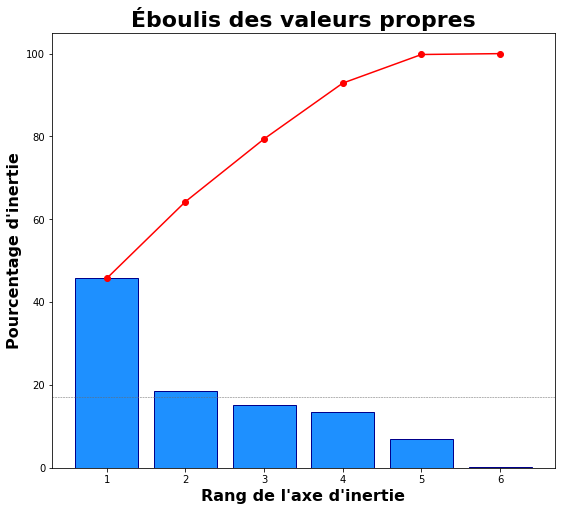

In [37]:
display_scree_plot(pca)

### <span style="color : #000000">**Tableau avec les 4 dimensions**</span> <a></a>

In [38]:
# projeter X sur les composantes principales
X_projected = pca.transform(X_scaled)

# Transformation en DataFrame pandas
data_pca_df = pd.DataFrame({
    "Dim1" : X_projected[:,0], 
    "Dim2" : X_projected[:,1],
    "Dim3" : X_projected[:,2], 
    "Dim4" : X_projected[:,3],
    "Pays" : pays
})

# Résultat (premières lignes)
data_pca_df.head()

,Dim1,Dim2,Dim3,Dim4,Pays
0,-2.979914,-0.449399,0.809531,-0.636269,Afghanistan
1,0.075776,-0.066253,-0.019734,1.418203,Albania
2,-1.678017,-0.114543,-0.110476,-0.103270,Algeria
3,-1.257278,0.586140,0.243595,-1.479531,Angola
4,3.873913,-2.442495,0.240658,-1.013785,Antigua and Barbuda


## <span style="color : #00BFFF">**Cercle des corrélations**</span> <a></a>

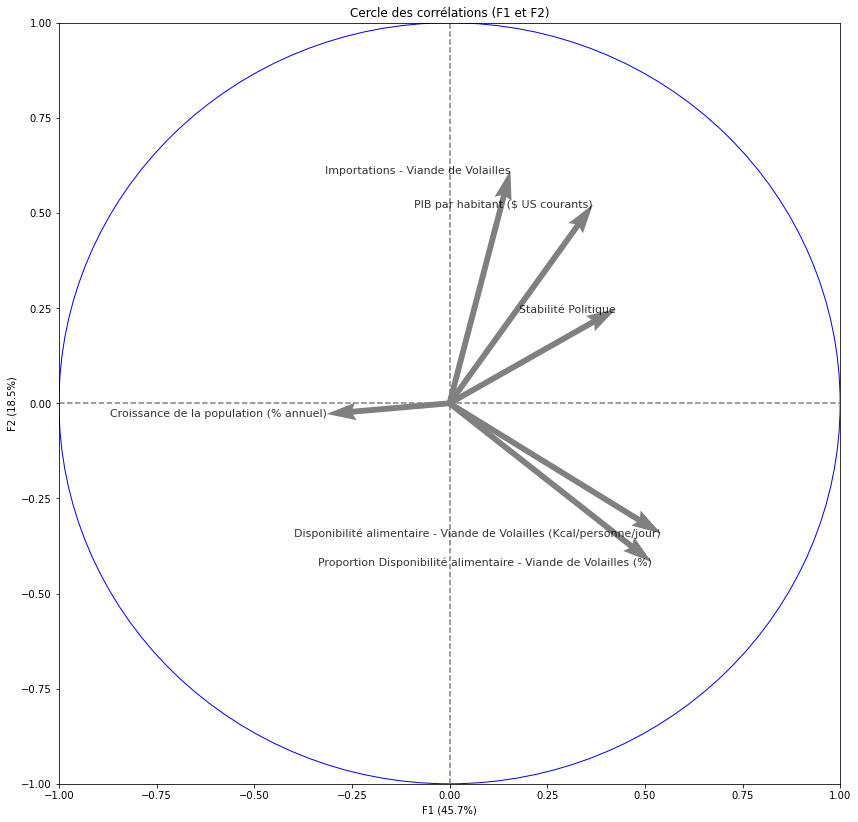

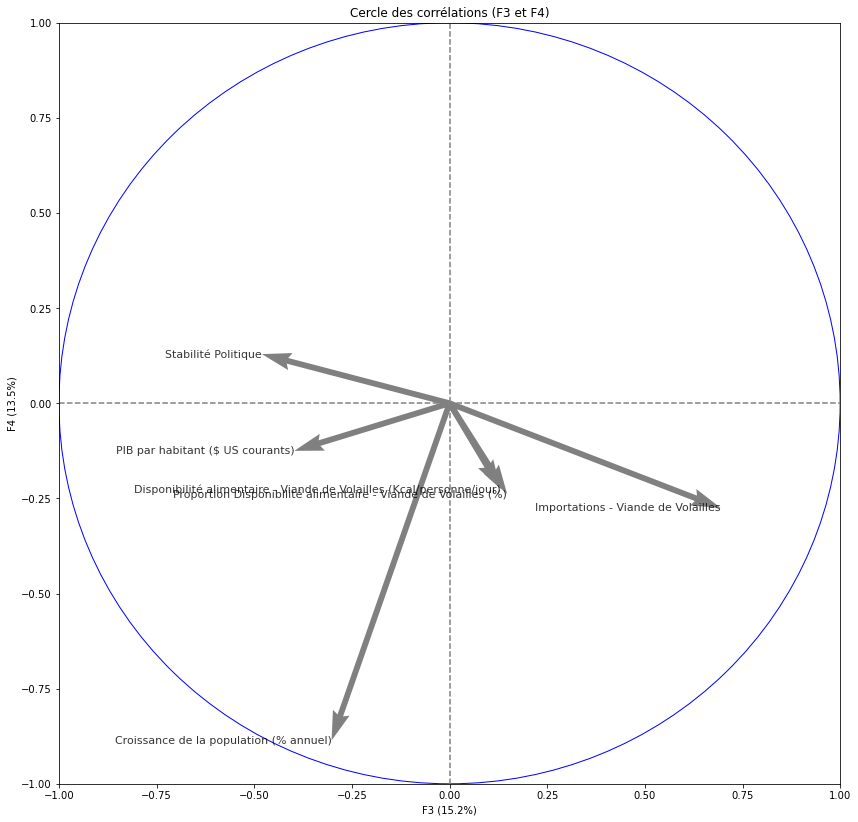

In [39]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3)], labels = np.array(features))

## <span style="color : #00BFFF">**Projection des individus**</span> <a></a>

### <span style="color : #000000">**Dimension F1 et F2**</span> <a></a>

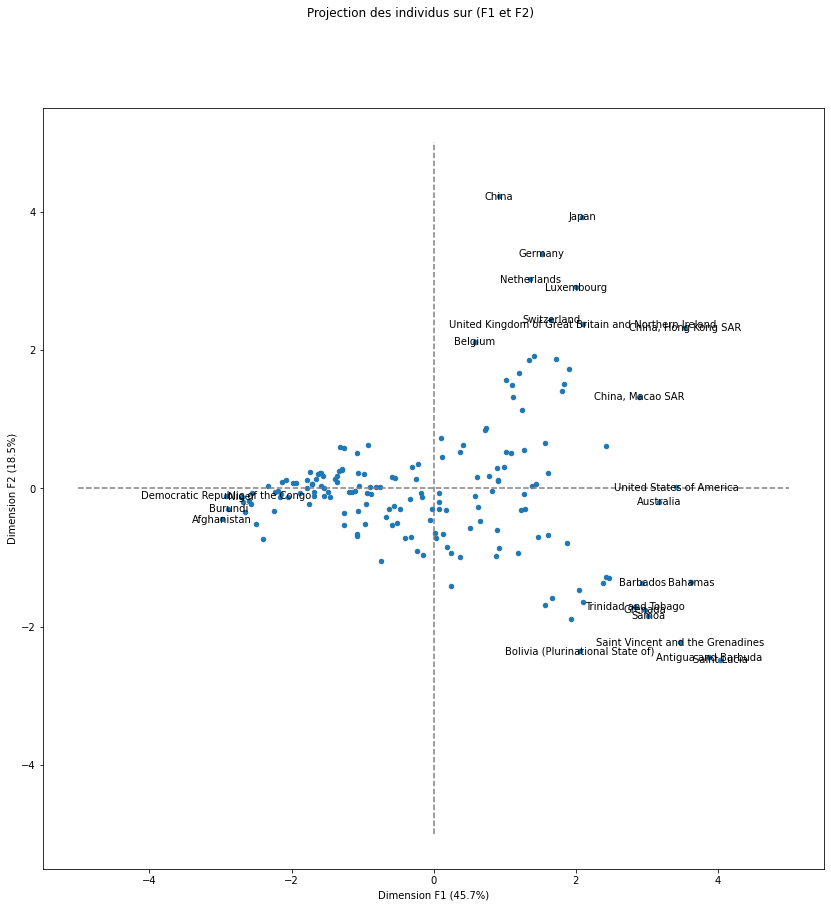

In [40]:
# utilisation de subplots nécessaire car annotation du graphique
fig, ax = plt.subplots(figsize=(14,14))
data_pca_df.plot.scatter("Dim1", "Dim2", ax = ax) # l'option ax permet de placer les points et le texte sur le même graphique

# boucle sur chaque pays
for k in data_pca_df.iterrows():
    # annotation uniquement si valeur absolue sur une de 2 dimensions importantes (valeurs choisies empiriquement)
    if (abs(k[1]['Dim1']) > 2.7) | (abs(k[1]['Dim2']) > 2):
        ax.annotate(k[1]["Pays"], (k[1]['Dim1'], k[1]['Dim2']), fontsize = 10, ha='center',va='center')

# affichage des lignes horizontales et verticales
plt.plot([-5, 5], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-5, 5], color='grey', ls='--')
        
plt.xlabel("Dimension F1 (45.7%)") 
plt.ylabel("Dimension F2 (18.5%)")
plt.suptitle("Projection des individus sur (F1 et F2)")
plt.show()

### <span style="color : #000000">**Dimension F3 et F4**</span> <a></a>

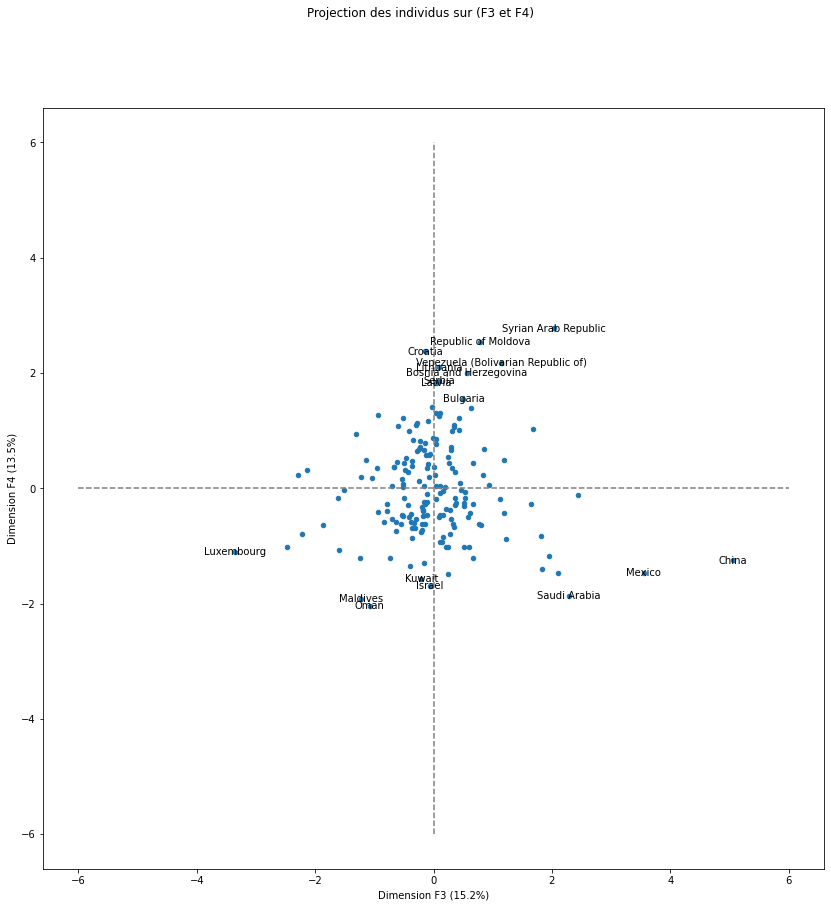

In [41]:
# utilisation de subplots nécessaire car annotation du graphique
fig, ax = plt.subplots(figsize=(14,14))
data_pca_df.plot.scatter("Dim3", "Dim4", ax = ax) # l'option ax permet de placer les points et le texte sur le même graphique

# boucle sur chaque pays
for k in data_pca_df.iterrows():
    # annotation uniquement si valeur absolue sur une de 2 dimensions importantes (valeurs choisies empiriquement)
    if (abs(k[1]['Dim3']) > 2.7) | (abs(k[1]['Dim4']) > 1.5):
        ax.annotate(k[1]["Pays"], (k[1]['Dim3'], k[1]['Dim4']), fontsize = 10, ha='center',va='center')

# affichage des lignes horizontales et verticales
plt.plot([-6, 6], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-6, 6], color='grey', ls='--')
        
plt.xlabel("Dimension F3 (15.2%)") 
plt.ylabel("Dimension F4 (13.5%)")
plt.suptitle("Projection des individus sur (F3 et F4)")
plt.show()

### <span style="color : #000000">**Centres des classes**</span> <a></a>

In [42]:
data_pca_k = data_pca_df.assign(classe = kmeans4.labels_)
data_centroid = data_pca_k.drop(columns = ["Pays", "classe"])

kmeans4c = KMeans(n_clusters = 4)
kmeans4c.fit(data_centroid)

KMeans(n_clusters=4)

## <span style="color : #00BFFF">**Projection des individus par groupe**</span> <a></a>

### <span style="color : #000000">**Dimension F1 et F2**</span> <a></a>

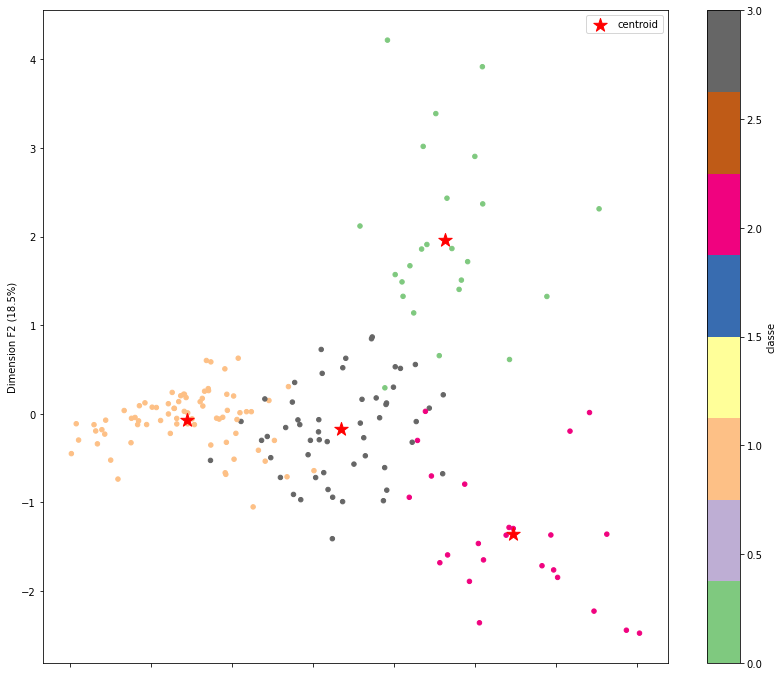

In [43]:
data_pca_k4 = data_pca_df.assign(classe = kmeans4.labels_)
data_pca_k4.plot.scatter(x = "Dim1", y = "Dim2", c = "classe", cmap = "Accent", figsize=(14,12))
plt.scatter(kmeans4c.cluster_centers_[:,0],kmeans4c.cluster_centers_[:,1], color='red', marker='*', s=200, label='centroid')
plt.legend()
plt.xlabel("Dimension F1 (45.7%)") 
plt.ylabel("Dimension F2 (18.5%)")
plt.show()

### <span style="color : #000000">**Dimension F3 et F4**</span> <a></a>

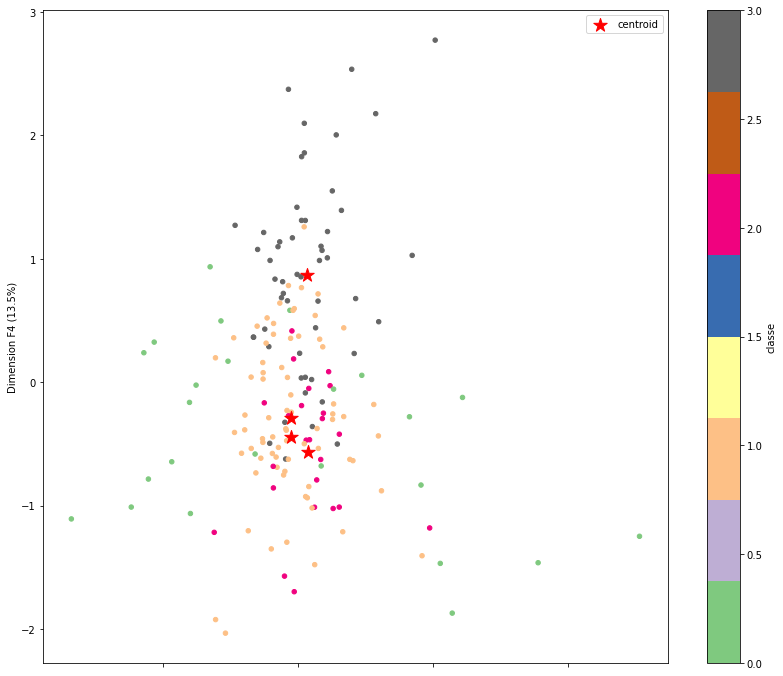

In [44]:
data_pca_k4.plot.scatter(x = "Dim3", y = "Dim4", c = "classe", cmap = "Accent", figsize=(14,12))
plt.scatter(kmeans4c.cluster_centers_[:,2],kmeans4c.cluster_centers_[:,3], color='red', marker='*', s=200, label='centroid')
plt.legend()
plt.xlabel("Dimension F3 (15.2%)") 
plt.ylabel("Dimension F4 (13.5%)")
plt.show()

## <span style="color : #8470FF">***Conclusion***</span> <a></a>

Selon nos analyses, nous pouvons conclure que le groupe de pays sélectionnés pour pouvoir exporter notre 'viande de volaille', est dans le groupe 3, car ils présentent une plus grande stabilité politique qui nous permettra d'entrer dans ces pays sans problèmes, de même leur PIB représente une grande stabilité et la demande qu'ils ont lors de l'importation de ce produit.

In [47]:
data_k4_real[data_k4_real.classe.isin([0])]

,Croissance de la population (% annuel),PIB par habitant ($ US courants),Stabilité Politique,Disponibilité alimentaire - Viande de Volailles (Kcal/personne/jour),Proportion Disponibilité alimentaire - Viande de Volailles (%),Importations - Viande de Volailles,classe
Pays,,,,,,,
Austria,0.694621,47309.051637,1.05,65.0,1.7639,110.0,0
Belgium,0.385228,44025.903247,0.43,39.0,1.0342,312.0,0
Canada,1.199521,44906.748920,1.10,154.0,4.3975,182.0,0
China,0.605245,8889.173494,-0.23,65.0,1.9739,1543.0,0
"China, Hong Kong SAR",0.748223,46705.027813,0.83,182.0,5.5709,907.0,0
"China, Macao SAR",1.579114,81043.968656,1.43,140.0,4.2450,23.0,0
Denmark,0.643351,57938.797728,0.87,97.0,2.8555,133.0,0
Finland,0.234671,46385.550876,1.08,68.0,2.0378,16.0,0
France,0.290202,38720.645922,0.28,90.0,2.5648,506.0,0
